In [ ]:
#!pip install pyarrow

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.orc as orc

filename = "./trades.orc"
df = pd.read_orc("./trades.orc")

# Data preparation:

### Conversión de formato de timestamp

In [4]:
df['Date'] = pd.to_datetime(df['time'], unit='ms')
df['Hour'] = df['Date'].dt.hour

### Encontrar valores NaN

In [5]:
df.shape
df[df.isna().any(axis=1)]

,trade_id,price,quantity,time,isSelling,Date,Hour
1337,NaN,NaN,NaN,NaN,None,NaT,NaN


### Dropear valores NaN

In [6]:
df=df.dropna().reset_index(drop=True).copy()
df[df.isna().any(axis=1)]
df.shape

(902954, 7)

### Valores duplicados:

In [7]:
df.loc[df.duplicated()]
#Valores duplicados en subconjuntos
#df.loc[df.duplicated(subset="trade_id")]

,trade_id,price,quantity,time,isSelling,Date,Hour


### Valores inválidos para precio

In [23]:
print(df[df["price"]<0].index)
df=df[df["price"]>0].copy().reset_index(drop=True)
print(df[df["price"]<0])

Int64Index([], dtype='int64')
Empty DataFrame
Columns: [trade_id, price, quantity, time, isSelling, Date, Hour, transaction_value, outcome]
Index: []


### Evolución del outcome respecto del tiempo

In [25]:
df["transaction_value"]=df["price"]*df["quantity"]
df.loc[df["isSelling"] == False, "transaction_value"] = df.loc[df["isSelling"] == False, "transaction_value"]*(-1)
df["outcome"]=df["transaction_value"].cumsum()
print(df.tail())

            trade_id    price  quantity          time isSelling  \
902948  1.118635e+09  1821.51    0.0061  1.680307e+12      True   
902949  1.118635e+09  1821.51    0.0153  1.680307e+12      True   
902950  1.118635e+09  1821.51    0.0341  1.680307e+12      True   
902951  1.118635e+09  1821.51    0.0330  1.680307e+12      True   
902952  1.118635e+09  1821.52    0.0305  1.680307e+12     False   

                                Date  Hour  transaction_value       outcome  
902948 2023-03-31 23:59:59.996000000  23.0          11.111211 -4.357775e+07  
902949 2023-03-31 23:59:59.996999936  23.0          27.869103 -4.357772e+07  
902950 2023-03-31 23:59:59.996999936  23.0          62.113491 -4.357766e+07  
902951 2023-03-31 23:59:59.999000064  23.0          60.109830 -4.357760e+07  
902952 2023-03-31 23:59:59.999000064  23.0         -55.556360 -4.357765e+07  


array([<Axes: ylabel='transaction_value'>], dtype=object)

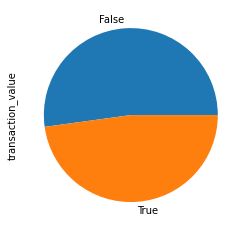

In [146]:
grouped_df = df.groupby("isSelling").sum()
grouped_df
abs(grouped_df["transaction_value"]).plot.pie(figsize=(4,4),subplots=True)

In [148]:
df["transaction_value_abs"]=abs(df["transaction_value"])
grouped_df = df.groupby("isSelling").sum().reset_index()#.copy()
grouped_df
#grouped_df["transaction_value"]=abs(grouped_df["transaction_value"])
fig = px.pie(grouped_df, values='transaction_value_abs', names='isSelling')
fig.show()

### Correlación entre características

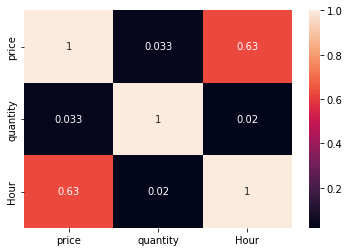

In [149]:
df_corr = df[["price","quantity","Hour"]].corr()
ax=sns.heatmap(df_corr,annot=True)

## Gráficas con agregación:

#### Filtrado por valor de transacción

In [ ]:
#df_prune = df[df["transaction_value"]>(1115+3995)]
#print(df.shape)
#print(df_prune.shape)
#import plotly.express as px
#fig = px.scatter(df_prune, x="Date", y="price", color="isSelling",
#                 size='quantity',  render_mode='webgl'
#                )
#fig.update_traces(marker_line=dict(width=0.5))
#fig.show()

#### Agregación por horas y minutos

In [79]:
#### Agregación por hora:
# "H" => hourly frequency
# "T, min" => minutely frequency

#Frequency="T"
Frequency="H"

df['agg_Date_'+Frequency] = df['Date'].dt.floor(Frequency)
print(df.groupby('agg_Date_'+Frequency).sum().reset_index())
print(df.groupby('agg_Date_'+Frequency).sum().reset_index().shape)
print('-------------------------------------')

grouped_data = df.groupby(['agg_Date_'+Frequency,"isSelling"])

#Usar una agregación específica para cada columna:
aggregation_dict = {'trade_id': 'mean', 'price': 'mean', 'quantity': 'mean', 
                    'time': 'min','Hour': 'min', 'transaction_value': 'sum',
                    'outcome': 'sum',  'transaction_value_abs': 'sum'}
aggregated_data = grouped_data.agg(aggregation_dict)
aggregated_data = aggregated_data.reset_index()
aggregated_data.to_csv("Aggregated_hour_trades.csv",index=False)
print('-------------------------------------')

#Plotly express con transaction values para los datos agregados
import plotly.express as px
fig = px.bar(aggregated_data, x='agg_Date_'+Frequency, y="transaction_value_abs", color="isSelling",
              barmode='group',
              color_discrete_sequence=px.colors.qualitative.Set1
                 #size='transaction_value_abs',  #render_mode='webgl'
                )
fig.show()


            agg_Date_H      trade_id         price    quantity          time  \
0  2023-03-31 00:00:00  3.905530e+13  6.289944e+07  24915.1765  5.870866e+16   
1  2023-03-31 01:00:00  4.920845e+13  7.968052e+07  28743.7893  7.396858e+16   
2  2023-03-31 02:00:00  3.063400e+13  4.940496e+07  11827.3276  4.604670e+16   
3  2023-03-31 03:00:00  2.721632e+13  4.394200e+07  11463.0527  4.090864e+16   
4  2023-03-31 04:00:00  2.664903e+13  4.297184e+07  10624.0933  4.005517e+16   
5  2023-03-31 05:00:00  3.127664e+13  5.039513e+07  13273.9367  4.700978e+16   
6  2023-03-31 06:00:00  2.448817e+13  3.937755e+07   9957.9000  3.680575e+16   
7  2023-03-31 07:00:00  5.707422e+13  9.130801e+07  35617.6813  8.578002e+16   
8  2023-03-31 08:00:00  4.227184e+13  6.778425e+07  19260.7312  6.353030e+16   
9  2023-03-31 09:00:00  3.776972e+13  6.048573e+07  12879.4554  5.676237e+16   
10 2023-03-31 10:00:00  2.885074e+13  4.629864e+07  12925.6571  4.335739e+16   
11 2023-03-31 11:00:00  3.622985e+13  5.

In [114]:
#### Agregación por hora:
# "H" => hourly frequency
# "T, min" => minutely frequency

#Frequency="T"
Frequency="H"

df['agg_Date_'+Frequency] = df['Date'].dt.floor(Frequency)
print(df.groupby('agg_Date_'+Frequency).sum().reset_index())
print(df.groupby('agg_Date_'+Frequency).sum().reset_index().shape)
print('-------------------------------------')

grouped_data = df.groupby(['agg_Date_'+Frequency,"isSelling"])

#Usar una agregación específica para cada columna:
aggregation_dict = {'trade_id': 'mean', 'price': 'mean', 'quantity': 'mean', 
                    'time': 'min','Hour': 'min', 'transaction_value': 'sum',
                    'outcome': 'sum',  'transaction_value_abs': 'sum'}
aggregated_data = grouped_data.agg(aggregation_dict)
aggregated_data = aggregated_data.reset_index()
aggregated_data.to_csv("Aggregated_"+Frequency+"_trades.csv",index=False)
print('-------------------------------------')

import plotly.express as px
fig = px.scatter(aggregated_data, x='agg_Date_'+Frequency, y="transaction_value_abs", 
                 color="isSelling",
              #barmode='group'
                 size='transaction_value_abs',  #render_mode='webgl'
                 #color_discrete_map= {'True': 'blue',
                 #                     'False': 'red'
                 #                    }
                 color_discrete_sequence=px.colors.qualitative.Set1
                )
fig.show()

            agg_Date_H      trade_id         price    quantity          time  \
0  2023-03-31 00:00:00  3.905530e+13  6.289944e+07  24915.1765  5.870866e+16   
1  2023-03-31 01:00:00  4.920845e+13  7.968052e+07  28743.7893  7.396858e+16   
2  2023-03-31 02:00:00  3.063400e+13  4.940496e+07  11827.3276  4.604670e+16   
3  2023-03-31 03:00:00  2.721632e+13  4.394200e+07  11463.0527  4.090864e+16   
4  2023-03-31 04:00:00  2.664903e+13  4.297184e+07  10624.0933  4.005517e+16   
5  2023-03-31 05:00:00  3.127664e+13  5.039513e+07  13273.9367  4.700978e+16   
6  2023-03-31 06:00:00  2.448817e+13  3.937755e+07   9957.9000  3.680575e+16   
7  2023-03-31 07:00:00  5.707422e+13  9.130801e+07  35617.6813  8.578002e+16   
8  2023-03-31 08:00:00  4.227184e+13  6.778425e+07  19260.7312  6.353030e+16   
9  2023-03-31 09:00:00  3.776972e+13  6.048573e+07  12879.4554  5.676237e+16   
10 2023-03-31 10:00:00  2.885074e+13  4.629864e+07  12925.6571  4.335739e+16   
11 2023-03-31 11:00:00  3.622985e+13  5.

In [116]:
#### Agregación por hora:
# "H" => hourly frequency
# "T, min" => minutely frequency

#Frequency="T"
Frequency="H"

df['agg_Date_'+Frequency] = df['Date'].dt.floor(Frequency)
print(df.groupby('agg_Date_'+Frequency).sum().reset_index())
print(df.groupby('agg_Date_'+Frequency).sum().reset_index().shape)
print('-------------------------------------')

grouped_data = df.groupby(['agg_Date_'+Frequency])

#Usar una agregación específica para cada columna:
aggregation_dict = {'trade_id': 'mean', 'price': 'mean', 'quantity': 'mean', 
                    'time': 'min','Hour': 'min', 'transaction_value': 'sum',
                    'outcome': 'last',  'transaction_value_abs': 'sum'}
aggregated_data = grouped_data.agg(aggregation_dict)
#print(aggregated_data)
aggregated_data = aggregated_data.reset_index()
print(aggregated_data)
aggregated_data['Outcome Balance'] = np.where(aggregated_data['outcome'] >= 0, 'Positive', 'Negative')
aggregated_data.to_csv("Aggregated_"+Frequency+"_outcome.csv",index=False)

print('-------------------------------------')

fig = px.bar(aggregated_data, x='agg_Date_'+Frequency, y="outcome", color="Outcome Balance",
              color_discrete_sequence=px.colors.qualitative.Set1
                )
fig.show()

            agg_Date_H      trade_id         price    quantity          time  \
0  2023-03-31 00:00:00  3.905530e+13  6.289944e+07  24915.1765  5.870866e+16   
1  2023-03-31 01:00:00  4.920845e+13  7.968052e+07  28743.7893  7.396858e+16   
2  2023-03-31 02:00:00  3.063400e+13  4.940496e+07  11827.3276  4.604670e+16   
3  2023-03-31 03:00:00  2.721632e+13  4.394200e+07  11463.0527  4.090864e+16   
4  2023-03-31 04:00:00  2.664903e+13  4.297184e+07  10624.0933  4.005517e+16   
5  2023-03-31 05:00:00  3.127664e+13  5.039513e+07  13273.9367  4.700978e+16   
6  2023-03-31 06:00:00  2.448817e+13  3.937755e+07   9957.9000  3.680575e+16   
7  2023-03-31 07:00:00  5.707422e+13  9.130801e+07  35617.6813  8.578002e+16   
8  2023-03-31 08:00:00  4.227184e+13  6.778425e+07  19260.7312  6.353030e+16   
9  2023-03-31 09:00:00  3.776972e+13  6.048573e+07  12879.4554  5.676237e+16   
10 2023-03-31 10:00:00  2.885074e+13  4.629864e+07  12925.6571  4.335739e+16   
11 2023-03-31 11:00:00  3.622985e+13  5.

In [104]:

Frequency="H"
#Frequency="H"

df['agg_Date_'+Frequency] = df['Date'].dt.floor(Frequency)
print(df.groupby('agg_Date_'+Frequency).sum().reset_index())
print(df.groupby('agg_Date_'+Frequency).sum().reset_index().shape)
print('-------------------------------------')

grouped_data = df.groupby(['agg_Date_'+Frequency])

#Usar una agregación específica para cada columna:
aggregation_dict = {'trade_id': 'mean', 'price': 'mean', 'quantity': 'mean', 
                    'time': 'min','Hour': 'min', 'transaction_value': 'sum',
                    'outcome': 'last',  'transaction_value_abs': 'sum'}
aggregated_data = grouped_data.agg(aggregation_dict)
#print(aggregated_data)
aggregated_data = aggregated_data.reset_index()
print(aggregated_data)
aggregated_data.to_csv("Aggregated_"+Frequency+"_outcome.csv",index=False)

print('-------------------------------------')

fig = px.bar(aggregated_data, x='agg_Date_'+Frequency, y="price",# color="isSelling",
              color_discrete_sequence=px.colors.qualitative.Set1[4:]
                )
fig.update_layout(yaxis_range=[aggregated_data["price"].min(),aggregated_data["price"].max()])
fig.show()

            agg_Date_H      trade_id         price    quantity          time  \
0  2023-03-31 00:00:00  3.905530e+13  6.289944e+07  24915.1765  5.870866e+16   
1  2023-03-31 01:00:00  4.920845e+13  7.968052e+07  28743.7893  7.396858e+16   
2  2023-03-31 02:00:00  3.063400e+13  4.940496e+07  11827.3276  4.604670e+16   
3  2023-03-31 03:00:00  2.721632e+13  4.394200e+07  11463.0527  4.090864e+16   
4  2023-03-31 04:00:00  2.664903e+13  4.297184e+07  10624.0933  4.005517e+16   
5  2023-03-31 05:00:00  3.127664e+13  5.039513e+07  13273.9367  4.700978e+16   
6  2023-03-31 06:00:00  2.448817e+13  3.937755e+07   9957.9000  3.680575e+16   
7  2023-03-31 07:00:00  5.707422e+13  9.130801e+07  35617.6813  8.578002e+16   
8  2023-03-31 08:00:00  4.227184e+13  6.778425e+07  19260.7312  6.353030e+16   
9  2023-03-31 09:00:00  3.776972e+13  6.048573e+07  12879.4554  5.676237e+16   
10 2023-03-31 10:00:00  2.885074e+13  4.629864e+07  12925.6571  4.335739e+16   
11 2023-03-31 11:00:00  3.622985e+13  5.

In [ ]:
### Histograma de tamaños de cadenas de compras y ventas.

In [ ]:
#### Agregación por cadenas de ventas y compras:

# Ask a question about the data:

1. What was the bot's outcome for that day?


In [ ]:
df["transaction_value"]=df["price"]*df["quantity"]
df_buy = df[df["isSelling"]==False]
df_sell = df[df["isSelling"]==True]
total_buy_value=df_buy["transaction_value"].sum()
total_sell_value=df_sell["transaction_value"].sum()
bot_outcome=total_sell_value-total_buy_value
print(bot_outcome)

2. How long was the longest chain of consecutive sells?

In [ ]:
#print("========================================================")
col_name="isSelling"
df['consecutive'] = df[col_name].groupby((df[col_name] != df[col_name].shift()).cumsum()).transform('size')# * df.Col2

#print("========== Max False")
#max_false = df[df[col_name]==False]["consecutive"].max() 
#print(df[df[col_name]==False]["consecutive"].max())

print("========== Max True")
max_true = df[df[col_name]==True]["consecutive"].max() 
print(df[df[col_name]==True]["consecutive"].max())

print("========== Cadena más larga con valores True")
df2 = df[df[col_name]==True ].copy()
df2 = df2[df2["consecutive"]==max_true]
#print(df2)



3. What was the price difference between the first and the last operation of that chain?

In [ ]:

print("---- First price in longest selling chain")
print(df.iloc[0,:]["price"])
print("---- Last price in longest selling chain")
print(df.iloc[-1,:]["price"])


In [ ]:
# OTRAS ESTADISTICAS:

#Account balance
#Trades opened
#Trades closed
#Profitable trades
#Losing trades
#W/L ratio: 




In [ ]:
#Renombrar la variable isSelling, y cambiar la leyenda de los plots. Podría ser "Trade type": "Sell"-"Buy"

#Luego calcular todas las estadísticas y guardarlas en un arreglo numpy en un csv. Luego eso se carga 
#desde el archivo de reportes.

#Más adelante veo si se pueden configurar los intervalos de tiempo para calcular las estadísticas.